In [24]:
import os 
import numpy as np
import keras
import tensorflow as tf 
import matplotlib.pyplot as plt

from keras import layers
from PIL import Image

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  99.1M      0  0:00:07  0:00:07 --:--:--  117M


In [27]:
!unzip -q kagglecatsanddogs_5340.zip 
!ls

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
 CDLA-Permissive-2.0.pdf   dogorcat.keras	       'readme[1].txt'
 PetImages		   kagglecatsanddogs_5340.zip


In [28]:
!ls PetImages

Cat  Dog


In [29]:
num_deleted = 0 
folder = "/kaggle/working/PetImages"

folders = [ os.path.join(folder, path) for path in os.listdir(folder) ]

for fold in folders:
    for fname in os.listdir(fold):
        fpath = os.path.join(fold, fname) 
        
        try:
            Image.open(fpath) 
            fobj = open(fpath, "rb") 
            is_jfif = b"JFIF" in fobj.peek(10) 
        except (IOError, SyntaxError) as e:
            os.remove(fpath) 
            num_deleted+=1
            
        finally:
            fobj.close() 
            
        if not is_jfif:
            if os.path.exists(fpath):  
                os.remove(fpath) 
                num_deleted +=1 
            


print(f"Total {num_deleted} images are deleted")

Total 0 images are deleted


In [30]:
class cnf:
    image_size = [180,180,3]
    batch_size = 64 
    seed = 24
    train_size = 0.9 
    
    
    
np.random.seed(cnf.seed)

In [31]:
cat_path = os.path.join(folder, "Cat") 
dog_path = os.path.join(folder, "Dog")

cat_paths = [os.path.join(cat_path, file_name) for file_name in os.listdir(cat_path)]
dog_paths = [os.path.join(dog_path, file_name) for file_name in os.listdir(dog_path)] 

cat_path_file_types = [file_path.split(".")[-1] for file_path in cat_paths] 
dog_path_file_types = [file_path.split(".")[-1] for file_path in dog_paths] 


print(f"Cat images : {len(cat_paths)}")
print(f"Dog images : {len(dog_paths)}")

print(f"Cat path file types : {set(cat_path_file_types)}")
print(f"Dog path file types : {set(dog_path_file_types)}")
print(f"Total images : {len(cat_paths) + len(dog_paths)}")

Cat images : 11741
Dog images : 11669
Cat path file types : {'jpg'}
Dog path file types : {'jpg'}
Total images : 23410


In [32]:
cat_paths = [cat_path for cat_path in cat_paths if cat_path.split(".")[-1] == "jpg"]
dog_paths = [dog_path for dog_path in dog_paths if dog_path.split(".")[-1] == 'jpg'] 

cat_path_file_types = [file_path.split(".")[-1] for file_path in cat_paths] 
dog_path_file_types = [file_path.split(".")[-1] for file_path in dog_paths] 

print(f"Cat images : {len(cat_paths)}")
print(f"Dog images : {len(dog_paths)}")

print(f"Cat path file types : {set(cat_path_file_types)}")
print(f"Dog path file types : {set(dog_path_file_types)}")
print(f"Total images : {len(cat_paths) + len(dog_paths)}")

Cat images : 11741
Dog images : 11669
Cat path file types : {'jpg'}
Dog path file types : {'jpg'}
Total images : 23410


In [33]:
def read_file(img_path):
    img = tf.io.read_file(img_path) 
    img = tf.io.decode_jpeg(img, channels=3) 
    img = tf.image.resize(img, size= cnf.image_size[:-1])
    img = tf.cast(img, tf.float32) / 255.0 
    return img
    
    

In [34]:
#cat - 0 
#dog - 1

cat_labels = [0,]* len(cat_paths) 
dog_labels = [1,]* len(dog_paths) 

img_paths = cat_paths + dog_paths 
labels = cat_labels + dog_labels

img_paths = np.array(img_paths) 
labels = np.array(labels) 

#random indexes 
idx = np.random.permutation(len(img_paths)) 
img_paths = img_paths[idx] 
labels = labels[idx] 

print(img_paths[:10]) 
print(labels[:10])

['/kaggle/working/PetImages/Dog/2343.jpg'
 '/kaggle/working/PetImages/Cat/8674.jpg'
 '/kaggle/working/PetImages/Cat/5483.jpg'
 '/kaggle/working/PetImages/Cat/6675.jpg'
 '/kaggle/working/PetImages/Dog/4567.jpg'
 '/kaggle/working/PetImages/Cat/2333.jpg'
 '/kaggle/working/PetImages/Dog/11810.jpg'
 '/kaggle/working/PetImages/Dog/43.jpg'
 '/kaggle/working/PetImages/Cat/3925.jpg'
 '/kaggle/working/PetImages/Cat/10658.jpg']
[1 0 0 0 1 0 1 1 0 0]


In [35]:
train_size = int(len(img_paths) * cnf.train_size) 
train_imgs = img_paths[:train_size] 
train_lbls = labels[:train_size] 

val_imgs = img_paths[train_size:] 
val_lbls = labels[train_size:] 

print(f"Total images : {len(img_paths)}")
print(len(train_imgs) + len(val_imgs))
print(f"Total train images : {len(train_imgs)}") 
print(f"Total Validation images : {len(val_imgs)}")


Total images : 23410
23410
Total train images : 21069
Total Validation images : 2341


In [36]:
train_ds = tf.data.Dataset.from_tensor_slices((train_imgs, train_lbls)) 
val_ds = tf.data.Dataset.from_tensor_slices((val_imgs, val_lbls)) 

def process_ds(img_path, label):
    img = read_file(img_path) 
    return img, label

train_ds = train_ds.map(process_ds).batch(cnf.batch_size).prefetch(tf.data.AUTOTUNE) 
val_ds = val_ds.map(process_ds).batch(cnf.batch_size).prefetch(tf.data.AUTOTUNE) 


    

In [37]:
images, labels = next(iter(train_ds)) 
images.shape, labels.shape

(TensorShape([64, 180, 180, 3]), TensorShape([64]))

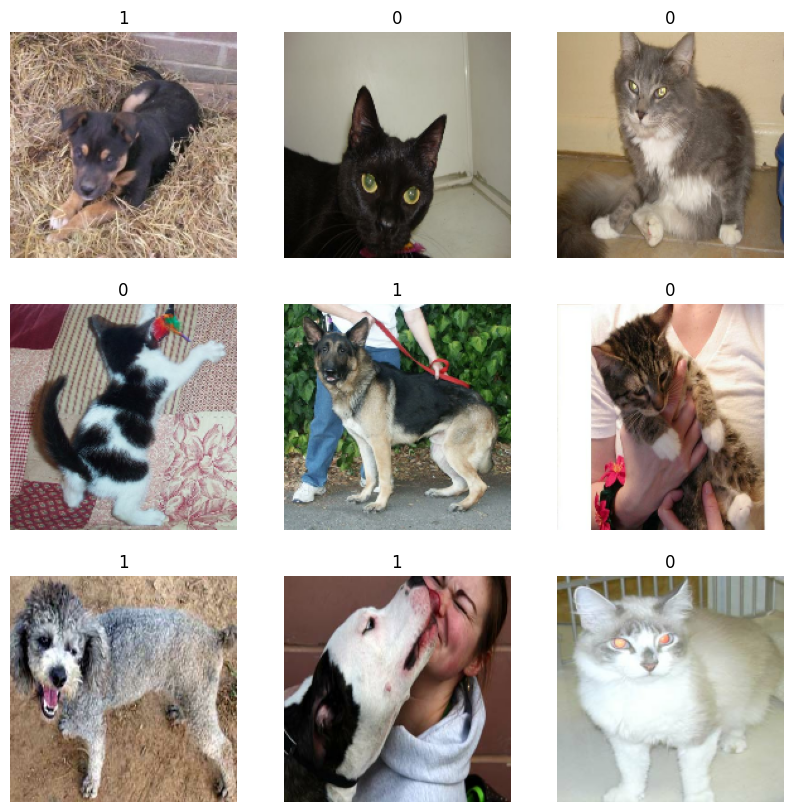

In [38]:
plt.figure(figsize=(10,10)) 

for i  in range(9):
    ax = plt.subplot(3,3,i+1) 
    plt.imshow(images[i]) 
    plt.title(f"{labels[i]}") 
    plt.axis('off') 
    
plt.show()

In [39]:
def get_model():
    inputs = layers.Input(shape=(cnf.image_size)) 
    x = inputs 
    x = layers.Conv2D(128,3,strides=2, padding='same')(x) 
    x = layers.BatchNormalization()(x) 
    x = layers.Activation('relu')(x) 
    
    prev_block_activation = x 
    
    for size in [256,512,728]:
        x = layers.Activation("relu")(x) 
        x = layers.SeparableConv2D(size, 3, padding='same')(x) 
        x = layers.BatchNormalization()(x) 
        
        x = layers.Activation("relu")(x) 
        x = layers.SeparableConv2D(size, 3, padding='same')(x) 
        x = layers.BatchNormalization()(x) 
        
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x) 
        
        residual = layers.Conv2D(size, 1, strides=2, padding='same')(prev_block_activation) 
        x = layers.add([x, residual]) 
        prev_block_activation = x
        
    x = layers.SeparableConv2D(1024, 3, padding='same')(x) 
    x = layers.BatchNormalization()(x) 
    x = layers.Activation("relu")(x) 
    x = layers.GlobalAveragePooling2D()(x) 
    
    x = layers.Dropout(0.25)(x) 
    x = layers.Dense(1, activation=None)(x) 
    return keras.models.Model(inputs, x) 

    

In [40]:
model = get_model() 
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 90, 90,    │      3,584 │ input_layer_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 90, 90,    │          0 │ activation_8[0][… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_7  │ (None, 90, 90,    │     34,176 │ activation_9[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_8  │ (None, 90, 90,    │     68,096 │ activation_10[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 45, 45,    │     33,024 │ activation_8[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 45, 45,    │          0 │ max_pooling2d_3[… │
│                     │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 45, 45,    │          0 │ add_3[0][0]       │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_9  │ (None, 45, 45,    │    133,888 │ activation_11[0]… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │      2,048 │ separable_conv2d… │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 45, 45,    │          0 │ batch_normalizat

 Total params: 2,731,065 (10.42 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

In [41]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
callbacks = [
    keras.callbacks.ModelCheckpoint("dogorcat.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=2)
]

model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name='acc')]
)

In [42]:
epochs = 15

model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/15
  6/330 ━━━━━━━━━━━━━━━━━━━━ 1:27 269ms/step - acc: 0.5661 - loss: 0.8601

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 21/330 ━━━━━━━━━━━━━━━━━━━━ 1:22 268ms/step - acc: 0.5705 - loss: 0.8019

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 65/330 ━━━━━━━━━━━━━━━━━━━━ 1:11 268ms/step - acc: 0.5928 - loss: 0.7300

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 76/330 ━━━━━━━━━━━━━━━━━━━━ 1:08 268ms/step - acc: 0.5947 - loss: 0.7227

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


146/330 ━━━━━━━━━━━━━━━━━━━━ 49s 268ms/step - acc: 0.6067 - loss: 0.6937

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/330 ━━━━━━━━━━━━━━━━━━━━ 44s 268ms/step - acc: 0.6097 - loss: 0.6881

184/330 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - acc: 0.6124 - loss: 0.6831

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


200/330 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step - acc: 0.6145 - loss: 0.6791

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


240/330 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - acc: 0.6201 - loss: 0.6698

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


262/330 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - acc: 0.6231 - loss: 0.6650

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


294/330 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - acc: 0.6273 - loss: 0.6587

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


310/330 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - acc: 0.6293 - loss: 0.6557

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - acc: 0.6319 - loss: 0.6521

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 114s 303ms/step - acc: 0.6320 - loss: 0.6519 - val_acc: 0.4951 - val_loss: 1.3487
Epoch 2/15
  6/330 ━━━━━━━━━━━━━━━━━━━━ 1:26 268ms/step - acc: 0.7842 - loss: 0.4577

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 21/330 ━━━━━━━━━━━━━━━━━━━━ 1:22 268ms/step - acc: 0.7608 - loss: 0.4868

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 65/330 ━━━━━━━━━━━━━━━━━━━━ 1:11 268ms/step - acc: 0.7590 - loss: 0.4900

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 76/330 ━━━━━━━━━━━━━━━━━━━━ 1:08 268ms/step - acc: 0.7584 - loss: 0.4909

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


146/330 ━━━━━━━━━━━━━━━━━━━━ 49s 268ms/step - acc: 0.7599 - loss: 0.4874

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/330 ━━━━━━━━━━━━━━━━━━━━ 44s 268ms/step - acc: 0.7613 - loss: 0.4853

184/330 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - acc: 0.7626 - loss: 0.4831

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


200/330 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step - acc: 0.7637 - loss: 0.4814

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


240/330 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - acc: 0.7662 - loss: 0.4771

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


262/330 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - acc: 0.7676 - loss: 0.4747

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


294/330 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - acc: 0.7695 - loss: 0.4713

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


310/330 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - acc: 0.7705 - loss: 0.4696

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - acc: 0.7717 - loss: 0.4675

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - acc: 0.7718 - loss: 0.4674 - val_acc: 0.8185 - val_loss: 0.4470
Epoch 3/15
  6/330 ━━━━━━━━━━━━━━━━━━━━ 1:27 269ms/step - acc: 0.8379 - loss: 0.3306

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 21/330 ━━━━━━━━━━━━━━━━━━━━ 1:22 268ms/step - acc: 0.8384 - loss: 0.3412

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 65/330 ━━━━━━━━━━━━━━━━━━━━ 1:11 268ms/step - acc: 0.8425 - loss: 0.3456

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 76/330 ━━━━━━━━━━━━━━━━━━━━ 1:08 268ms/step - acc: 0.8424 - loss: 0.3461

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


146/330 ━━━━━━━━━━━━━━━━━━━━ 49s 268ms/step - acc: 0.8458 - loss: 0.3409

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/330 ━━━━━━━━━━━━━━━━━━━━ 44s 268ms/step - acc: 0.8469 - loss: 0.3389

184/330 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - acc: 0.8480 - loss: 0.3370

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


200/330 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step - acc: 0.8488 - loss: 0.3355

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


240/330 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - acc: 0.8506 - loss: 0.3321

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


262/330 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - acc: 0.8515 - loss: 0.3305

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


294/330 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - acc: 0.8526 - loss: 0.3284

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


310/330 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - acc: 0.8531 - loss: 0.3274

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - acc: 0.8538 - loss: 0.3262

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - acc: 0.8538 - loss: 0.3261 - val_acc: 0.8642 - val_loss: 0.3207
Epoch 4/15
  6/330 ━━━━━━━━━━━━━━━━━━━━ 1:26 268ms/step - acc: 0.9078 - loss: 0.2301

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 21/330 ━━━━━━━━━━━━━━━━━━━━ 1:22 268ms/step - acc: 0.9043 - loss: 0.2354

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 65/330 ━━━━━━━━━━━━━━━━━━━━ 1:11 268ms/step - acc: 0.9007 - loss: 0.2376

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 76/330 ━━━━━━━━━━━━━━━━━━━━ 1:08 268ms/step - acc: 0.9002 - loss: 0.2381

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


146/330 ━━━━━━━━━━━━━━━━━━━━ 49s 268ms/step - acc: 0.8996 - loss: 0.2375

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/330 ━━━━━━━━━━━━━━━━━━━━ 44s 268ms/step - acc: 0.8996 - loss: 0.2366

184/330 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - acc: 0.8998 - loss: 0.2357

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


200/330 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step - acc: 0.9000 - loss: 0.2349

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


240/330 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - acc: 0.9006 - loss: 0.2328

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


262/330 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - acc: 0.9008 - loss: 0.2319

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


294/330 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - acc: 0.9012 - loss: 0.2307

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


310/330 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - acc: 0.9013 - loss: 0.2302

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - acc: 0.9016 - loss: 0.2295

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - acc: 0.9016 - loss: 0.2294 - val_acc: 0.8808 - val_loss: 0.3023
Epoch 5/15
  6/330 ━━━━━━━━━━━━━━━━━━━━ 1:26 268ms/step - acc: 0.9200 - loss: 0.1748

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 21/330 ━━━━━━━━━━━━━━━━━━━━ 1:22 268ms/step - acc: 0.9181 - loss: 0.1735

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 65/330 ━━━━━━━━━━━━━━━━━━━━ 1:10 268ms/step - acc: 0.9226 - loss: 0.1722

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 76/330 ━━━━━━━━━━━━━━━━━━━━ 1:08 268ms/step - acc: 0.9227 - loss: 0.1731

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


146/330 ━━━━━━━━━━━━━━━━━━━━ 49s 268ms/step - acc: 0.9232 - loss: 0.1758

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/330 ━━━━━━━━━━━━━━━━━━━━ 44s 268ms/step - acc: 0.9234 - loss: 0.1757

184/330 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - acc: 0.9235 - loss: 0.1755

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


200/330 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step - acc: 0.9237 - loss: 0.1751

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


240/330 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - acc: 0.9244 - loss: 0.1738

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


262/330 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - acc: 0.9246 - loss: 0.1734

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


294/330 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - acc: 0.9249 - loss: 0.1728

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


310/330 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - acc: 0.9250 - loss: 0.1726

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - acc: 0.9251 - loss: 0.1723

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 275ms/step - acc: 0.9251 - loss: 0.1723 - val_acc: 0.7817 - val_loss: 0.8757
Epoch 6/15
  6/330 ━━━━━━━━━━━━━━━━━━━━ 1:27 269ms/step - acc: 0.9553 - loss: 0.1279

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 21/330 ━━━━━━━━━━━━━━━━━━━━ 1:22 268ms/step - acc: 0.9441 - loss: 0.1376

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 65/330 ━━━━━━━━━━━━━━━━━━━━ 1:10 268ms/step - acc: 0.9431 - loss: 0.1382

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 76/330 ━━━━━━━━━━━━━━━━━━━━ 1:08 268ms/step - acc: 0.9430 - loss: 0.1380

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


146/330 ━━━━━━━━━━━━━━━━━━━━ 49s 268ms/step - acc: 0.9430 - loss: 0.1383

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/330 ━━━━━━━━━━━━━━━━━━━━ 44s 268ms/step - acc: 0.9431 - loss: 0.1381

184/330 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - acc: 0.9432 - loss: 0.1378

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


200/330 ━━━━━━━━━━━━━━━━━━━━ 34s 268ms/step - acc: 0.9433 - loss: 0.1373

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


240/330 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - acc: 0.9437 - loss: 0.1363

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


262/330 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - acc: 0.9438 - loss: 0.1360

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


294/330 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - acc: 0.9439 - loss: 0.1356

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


310/330 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - acc: 0.9440 - loss: 0.1353

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - acc: 0.9441 - loss: 0.1350

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 275ms/step - acc: 0.9441 - loss: 0.1350 - val_acc: 0.7907 - val_loss: 0.8726


In [43]:
!pip install -q keras2onnx onnx

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 14.0.2 which is incompatible.
cudf 24.4.1 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.5.0 which is incompatible.
google-cloud-aiplatf